In [3]:
# ------------------------------------------------------------------
# Step 0 – Imports, File Paths, and Inspect Files
# ------------------------------------------------------------------

# Core libraries
import geopandas as gpd
import pandas as pd
import numpy as np

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Optional: for advanced clustering
# import hdbscan

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
gpkg_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/LSOA_CT_Demand_with_Demographics_2024_v1.gpkg"
health_csv = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/filtered_general_health_lsoas.csv"
rural_urban_csv = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/filtered_rural_urban_lsoas.csv"
imd_csv = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/lsoa_imd19_complete.csv"

# Load files
gdf = gpd.read_file(gpkg_path)
df_health = pd.read_csv(health_csv)
df_rural_urban = pd.read_csv(rural_urban_csv)
df_imd = pd.read_csv(imd_csv)

# Inspect structure
print("\n--- GPKG ---")
print("Shape:", gdf.shape)
print("Columns:", list(gdf.columns))

print("\n--- Health CSV ---")
print("Shape:", df_health.shape)
print("Columns:", list(df_health.columns))

print("\n--- Rural/Urban CSV ---")
print("Shape:", df_rural_urban.shape)
print("Columns:", list(df_rural_urban.columns))

print("\n--- IMD CSV ---")
print("Shape:", df_imd.shape)
print("Columns:", list(df_imd.columns))

# Check for LSOA join key
print("\n--- Join Key Presence ('lsoa21cd') ---")
print("In GPKG:", 'lsoa21cd' in gdf.columns)
print("In Health CSV:", 'lsoa21cd' in df_health.columns)
print("In Rural/Urban CSV:", 'lsoa21cd' in df_rural_urban.columns)
print("In IMD CSV:", 'lsoa21cd' in df_imd.columns)

# Preview join keys
print("\n--- Sample LSOA Codes ---")
print("GPKG:", gdf['lsoa21cd'].head().tolist())
print("Health CSV:", df_health['lsoa21cd'].head().tolist())
print("Rural/Urban CSV:", df_rural_urban['lsoa21cd'].head().tolist())
print("IMD CSV:", df_imd['lsoa21cd'].head().tolist())



--- GPKG ---
Shape: (3451, 51)
Columns: ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'ct_total_demand', 'ct_age_0_4', 'ct_age_5_9', 'ct_age_10_14', 'ct_age_15_19', 'ct_age_20_24', 'ct_age_25_29', 'ct_age_30_34', 'ct_age_35_39', 'ct_age_40_44', 'ct_age_45_49', 'ct_age_50_54', 'ct_age_55_59', 'ct_age_60_64', 'ct_age_65_69', 'ct_age_70_74', 'ct_age_75_79', 'ct_age_80_84', 'ct_age_85_plus', 'geometry']

--- Health CSV ---
Shape: (3451, 7)
Columns: ['lsoa21cd', 'General health: Total: All usual residents', 'General health: Very good health', 'General health: Good health', 'General health: Fair health', 'General health: Bad health', 'General health: Very bad health'

In [4]:
# ------------------------------------------------------------------
# Step 1 – Merge CSV Data into the GeoDataFrame
# ------------------------------------------------------------------

# Sanity check: ensure no duplicates in CSVs by LSOA code
assert df_health['lsoa21cd'].is_unique, "Health CSV has duplicate LSOAs"
assert df_rural_urban['lsoa21cd'].is_unique, "Rural/Urban CSV has duplicate LSOAs"
assert df_imd['lsoa21cd'].is_unique, "IMD CSV has duplicate LSOAs"

# Merge each dataset into the GeoDataFrame
gdf = gdf.merge(df_health, on='lsoa21cd', how='left')
gdf = gdf.merge(df_rural_urban, on='lsoa21cd', how='left')
gdf = gdf.merge(df_imd, on='lsoa21cd', how='left')

# Confirm merge success
print("\n--- Merged GeoDataFrame ---")
print("Shape:", gdf.shape)
new_columns = [col for col in gdf.columns if col not in ['geometry']]
print("Columns (excluding geometry):", new_columns)

# Optional: save merged GeoDataFrame for reuse
merged_gpkg_path = gpkg_path.replace(".gpkg", "_merged_v1.gpkg")
gdf.to_file(merged_gpkg_path, driver="GPKG")
print("Saved merged GeoDataFrame to:", merged_gpkg_path)



--- Merged GeoDataFrame ---
Shape: (3451, 60)
Columns (excluding geometry): ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus', 'lat', 'long', 'bng_e', 'bng_n', 'lsoa21nm', 'ct_total_demand', 'ct_age_0_4', 'ct_age_5_9', 'ct_age_10_14', 'ct_age_15_19', 'ct_age_20_24', 'ct_age_25_29', 'ct_age_30_34', 'ct_age_35_39', 'ct_age_40_44', 'ct_age_45_49', 'ct_age_50_54', 'ct_age_55_59', 'ct_age_60_64', 'ct_age_65_69', 'ct_age_70_74', 'ct_age_75_79', 'ct_age_80_84', 'ct_age_85_plus', 'General health: Total: All usual residents', 'General health: Very good health', 'General health: Good health', 'General health: Fair health', 'General health: Bad health', 'General health: Very bad health', 'RUC21NM', 'Urban_rural_flag', 'I

In [6]:
# ------------------------------------------------------------------
# Step 2 – Phase 1: Core Feature Engineering
# ------------------------------------------------------------------

# Create a working copy to avoid modifying the original GeoDataFrame
gdf_features = gdf.copy()

# ------------------------------------------------------------------
# 1. Filter out invalid LSOAs (zero or missing population)
# ------------------------------------------------------------------
# Drop rows where total_population is zero or missing to avoid division errors
gdf_features = gdf_features[gdf_features['total_population'] > 0].copy()

# ------------------------------------------------------------------
# 2. Define and compute age band proportions
# ------------------------------------------------------------------
age_band_cols = [
    'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24',
    'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49',
    'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74',
    'age_75_79', 'age_80_84', 'age_85_plus'
]

# Compute age proportions relative to total population
for col in age_band_cols:
    gdf_features[col + '_prop'] = gdf_features[col] / gdf_features['total_population']

# ------------------------------------------------------------------
# 3. Compute CT demand per 1,000 population
# ------------------------------------------------------------------
gdf_features['ct_demand_per_1000'] = (
    gdf_features['ct_total_demand'] / gdf_features['total_population']
) * 1000

# ------------------------------------------------------------------
# 4. Create feature matrix for clustering
# ------------------------------------------------------------------
feature_cols = [col + '_prop' for col in age_band_cols] + ['ct_demand_per_1000']
df_cluster_input = gdf_features[feature_cols].copy()

# ------------------------------------------------------------------
# 5. Inspect final matrix
# ------------------------------------------------------------------
print("Final feature matrix shape:", df_cluster_input.shape)
print("Any missing values?", df_cluster_input.isnull().any().any())
print(df_cluster_input.describe().T)


Final feature matrix shape: (3449, 19)
Any missing values? False
                     count        mean        std        min        25%  \
age_0_4_prop        3449.0    0.047641   0.017424   0.006069   0.035935   
age_5_9_prop        3449.0    0.054243   0.016876   0.003314   0.043785   
age_10_14_prop      3449.0    0.055945   0.016057   0.002013   0.046730   
age_15_19_prop      3449.0    0.053332   0.031543   0.008137   0.042315   
age_20_24_prop      3449.0    0.056810   0.049194   0.010305   0.037310   
age_25_29_prop      3449.0    0.057509   0.027574   0.009925   0.038461   
age_30_34_prop      3449.0    0.061742   0.024616   0.010967   0.044045   
age_35_39_prop      3449.0    0.059780   0.018674   0.013452   0.046911   
age_40_44_prop      3449.0    0.057628   0.013183   0.011772   0.048958   
age_45_49_prop      3449.0    0.061403   0.011510   0.012100   0.054668   
age_50_54_prop      3449.0    0.070219   0.013564   0.003646   0.062971   
age_55_59_prop      3449.0    0.072

/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

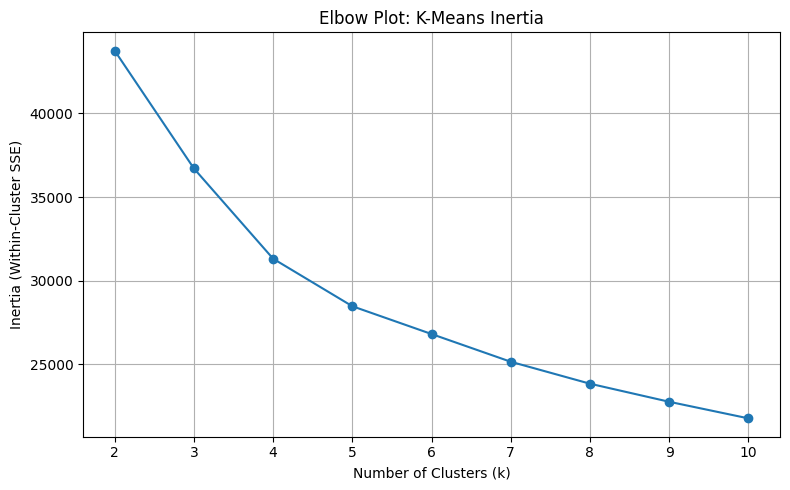

/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/diagnostic-demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

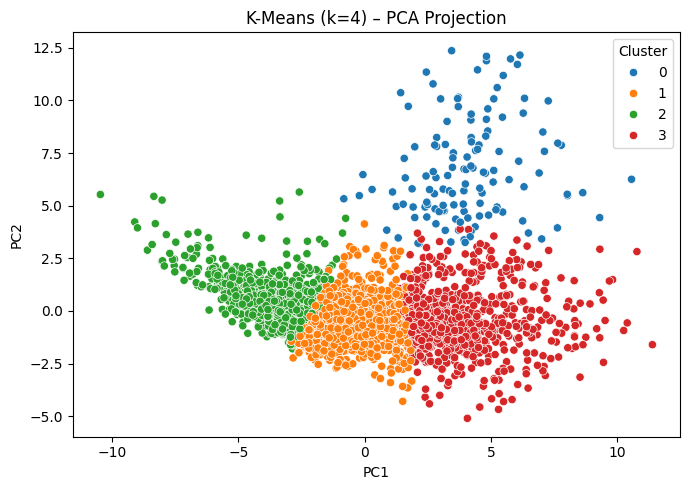

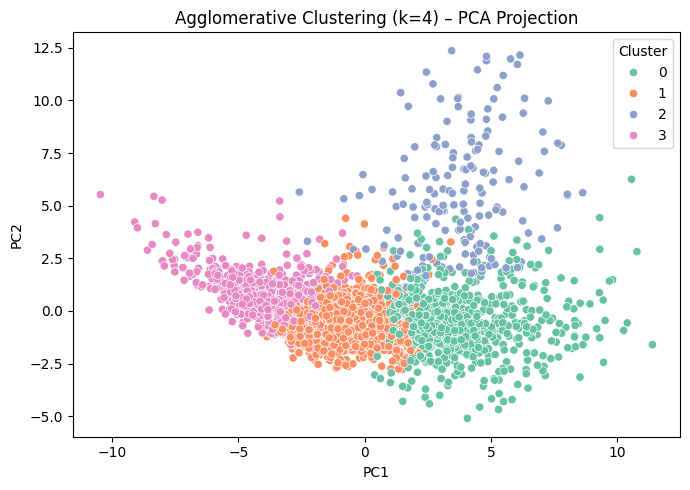

Cluster labels added to GeoDataFrame: ['kmeans_k3', 'kmeans_k4', 'kmeans_k5', 'kmeans_k6', 'agglo_k3', 'agglo_k4', 'agglo_k5', 'agglo_k6']


In [7]:
# ------------------------------------------------------------------
# Step 3 – Standardisation and Clustering (All 6 Components)
# ------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Standardise the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_input)

# 2. Elbow plot to choose optimal k
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot: K-Means Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Apply K-Means clustering for 3–6 clusters
kmeans_labels = {}
for k in range(3, 7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    kmeans_labels[f'kmeans_k{k}'] = labels

# 4. Apply Agglomerative Clustering for 3–6 clusters
agglo_labels = {}
for k in range(3, 7):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled)
    agglo_labels[f'agglo_k{k}'] = labels

# 5. PCA for 2D visualisation of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Add cluster labels (e.g., k=4) to PCA DataFrame for plotting
pca_df['kmeans_k4'] = kmeans_labels['kmeans_k4']
pca_df['agglo_k4'] = agglo_labels['agglo_k4']

# Plot K-Means k=4
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_k4', palette='tab10')
plt.title('K-Means (k=4) – PCA Projection')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Plot Agglomerative k=4
plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='agglo_k4', palette='Set2')
plt.title('Agglomerative Clustering (k=4) – PCA Projection')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 6. Join cluster labels back to GeoDataFrame for mapping or analysis
for colname, labels in kmeans_labels.items():
    gdf_features[colname] = labels

for colname, labels in agglo_labels.items():
    gdf_features[colname] = labels

# Summary of added columns
print("Cluster labels added to GeoDataFrame:", list(kmeans_labels.keys()) + list(agglo_labels.keys()))


Numeric Cluster Profile (KMeans k=4):


,age_0_4_prop,age_5_9_prop,age_10_14_prop,age_15_19_prop,age_20_24_prop,age_25_29_prop,age_30_34_prop,age_35_39_prop,age_40_44_prop,age_45_49_prop,...,age_65_69_prop,age_70_74_prop,age_75_79_prop,age_80_84_prop,age_85_plus_prop,ct_demand_per_1000,IMD19,General health: Fair health,General health: Bad health,General health: Very bad health
kmeans_k4,,,,,,,,,,,,,,,,,,,,,
0,0.03,0.03,0.03,0.13,0.26,0.12,0.08,0.06,0.04,0.04,...,0.03,0.02,0.02,0.01,0.01,68.72,17130.75,180.04,49.40,13.73
1,0.05,0.06,0.06,0.05,0.05,0.05,0.06,0.06,0.06,0.06,...,0.06,0.06,0.05,0.03,0.03,117.76,19209.46,218.69,65.33,18.68
2,0.03,0.04,0.05,0.04,0.04,0.04,0.04,0.04,0.05,0.06,...,0.08,0.09,0.07,0.05,0.05,151.02,20502.43,235.89,67.06,19.16
3,0.07,0.07,0.06,0.05,0.06,0.08,0.09,0.08,0.07,0.06,...,0.04,0.03,0.02,0.02,0.02,84.43,14226.43,209.53,67.82,19.17


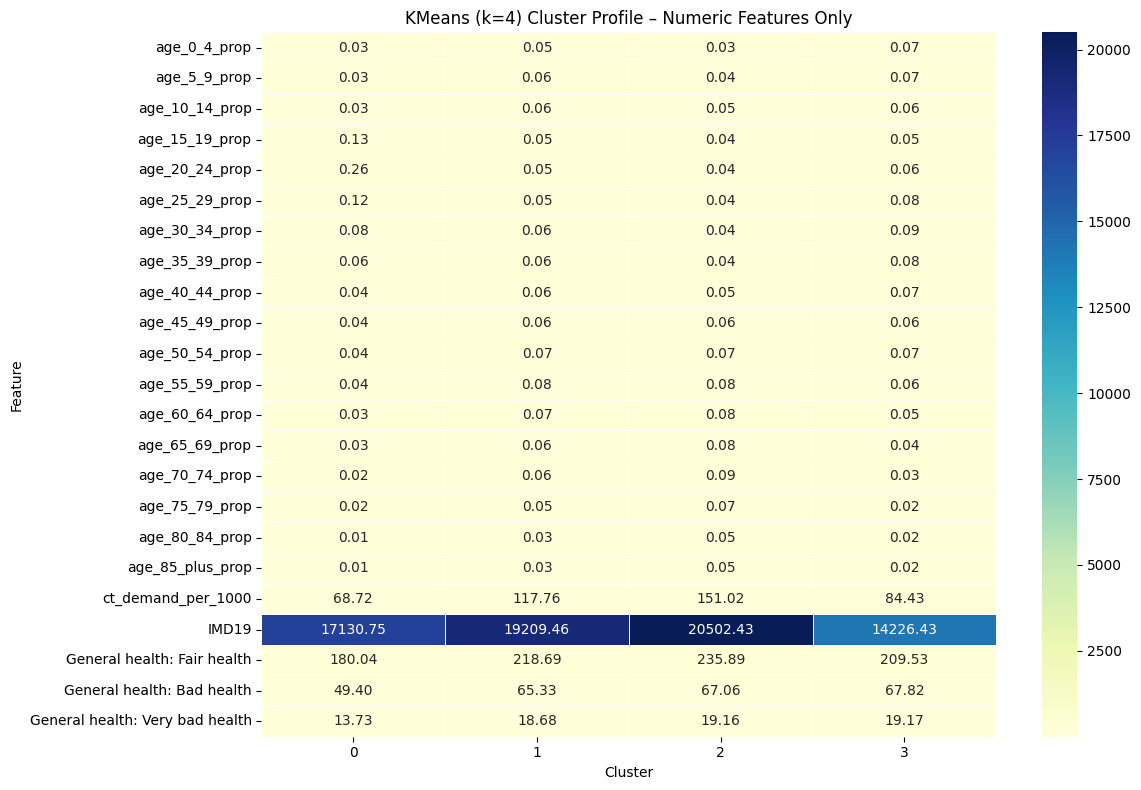

In [9]:
# ------------------------------------------------------------------
# Step 4 – Cluster Profiling (KMeans k=4) – Fixed
# ------------------------------------------------------------------

# 1. Define core features (age proportions + CT demand)
profile_cols = [col + '_prop' for col in age_band_cols] + ['ct_demand_per_1000']

# Optional: add only numeric contextual variables
numeric_contextual = [
    'IMD19',
    'General health: Fair health',
    'General health: Bad health',
    'General health: Very bad health'
]

# Only include those that exist
numeric_contextual = [col for col in numeric_contextual if col in gdf_features.columns]
profile_cols += numeric_contextual

# 2. Compute cluster-wise means
cluster_profile = gdf_features.groupby('kmeans_k4')[profile_cols].mean().round(2)

# 3. Show as DataFrame
print("Numeric Cluster Profile (KMeans k=4):")
display(cluster_profile)

# 4. Heatmap of cluster profile
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile.T, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title("KMeans (k=4) Cluster Profile – Numeric Features Only")
plt.ylabel("Feature")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()


In [10]:
# Proportion of rural LSOAs per cluster
if 'Urban_rural_flag' in gdf_features.columns:
    rural_prop = (
        gdf_features.assign(is_rural=(gdf_features['Urban_rural_flag'] == 'Rural'))
        .groupby('kmeans_k4')['is_rural']
        .mean()
        .round(2)
    )
    print("\nProportion of Rural LSOAs by Cluster:")
    print(rural_prop)



Proportion of Rural LSOAs by Cluster:
kmeans_k4
0    0.04
1    0.33
2    0.54
3    0.05
Name: is_rural, dtype: float64


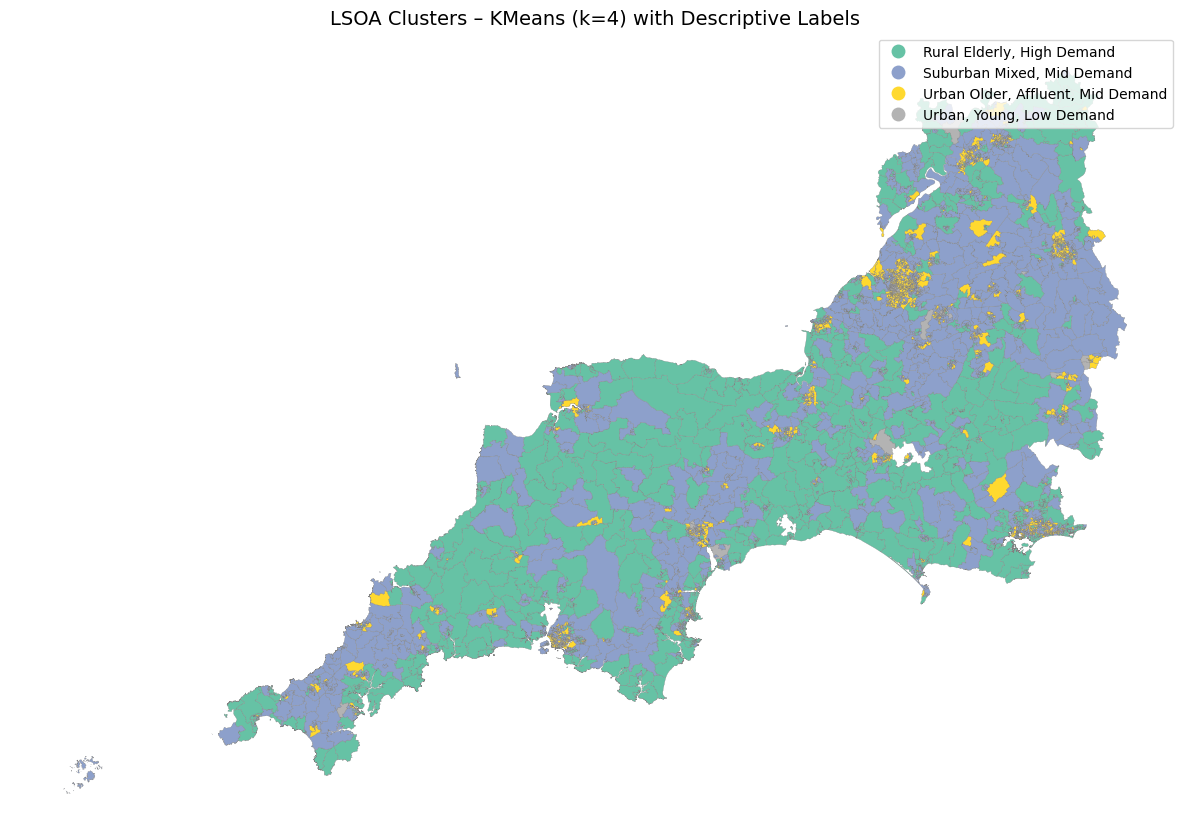

In [12]:
# ------------------------------------------------------------------
# Step 5 – Geographic Mapping of Named KMeans (k=4) Clusters
# ------------------------------------------------------------------

# Define mapping from cluster number to descriptive label
cluster_labels = {
    0: "Urban, Young, Low Demand",
    1: "Suburban Mixed, Mid Demand",
    2: "Rural Elderly, High Demand",
    3: "Urban Older, Affluent, Mid Demand"
}

# Add labelled cluster column to GeoDataFrame
gdf_features['kmeans_k4_label'] = gdf_features['kmeans_k4'].map(cluster_labels)

# Optional: project for better UK plotting (British National Grid)
gdf_mapped = gdf_features.to_crs(epsg=27700)

# Plot with named clusters
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_mapped.plot(column='kmeans_k4_label',
                cmap='Set2',
                linewidth=0.2,
                edgecolor='grey',
                legend=True,
                ax=ax)

ax.set_title('LSOA Clusters – KMeans (k=4) with Descriptive Labels', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import silhouette_score

# Use the same feature matrix and cluster labels
score = silhouette_score(df_cluster_input, gdf_features['kmeans_k4'])
print(f"Silhouette Score (k=4): {score:.3f}")


Silhouette Score (k=4): 0.366


### Silhouette Score Interpretation

| Score Range | Interpretation                        |
|-------------|----------------------------------------|
| 0.70 – 1.0  | Strong, well-separated clusters        |
| 0.50 – 0.70 | Reasonable structure, useful clusters  |
| 0.25 – 0.50 | Weak structure, potentially noisy      |
| < 0.25      | Overlapping clusters, not meaningful   |
